# Imports

In [1]:
import os

import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smapi
import statsmodels.tsa.stattools as smtools

import core.config.config_ as cconconf
import core.plotting as coplotti
import helpers.hs3 as hs3
import im_v2.common.universe as ivcu
import research_amp.cc.statistics as ramccsta

AM_AWS_PROFILE = "am"

/app/core/explore.py:39: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import tqdm.autonotebook as tauton


# Config

In [2]:
def get_cmtask323_config() -> cconconf.Config:
    """
    Get task323-specific config.
    """
    config = cconconf.Config()
    # Load parameters.
    config.add_subconfig("load")
    config["load"]["aws_profile"] = AM_AWS_PROFILE
    config["load"]["data_dir"] = os.path.join(
        hs3.get_s3_bucket_path(AM_AWS_PROFILE), "data"
    )
    # Data parameters.
    config.add_subconfig("data")
    config["data"]["data_type"] = "OHLCV"
    config["data"]["universe_version"] = "v03"
    config["data"]["vendor"] = "CCXT"
    # Column names.
    config.add_subconfig("column_names")
    config["column_names"]["volume"] = "volume"
    config["column_names"]["currency_pair"] = "currency_pair"
    config["column_names"]["exchange"] = "exchange_id"
    config["column_names"]["close"] = "close"
    return config


config = get_cmtask323_config()
print(config)

load:
  aws_profile: am
  data_dir: s3://alphamatic-data/data
data:
  data_type: OHLCV
  universe_version: v03
  vendor: CCXT
column_names:
  volume: volume
  currency_pair: currency_pair
  exchange: exchange_id
  close: close


# Functions

In [3]:
def compute_volatility_for_each_coin(data: pd.DataFrame, freq: str, span: int):
    """
    Load and transform each (exchange-coin) dataframe to compute 18-period ema
    volatility.

    Parameters: initial DataFrame from the universe, resampling frequency
    """
    data["date"] = data.index
    # TODO(Max): Try out our resampe_df() for resampling.
    resample_close = data.groupby(
        ["currency_pair", "exchange_id", pd.Grouper(key="date", freq=freq)]
    )["close"].last()
    vix_df = resample_close.pct_change().transform(
        lambda x: x.ewm(span=span, adjust=False).std()
    )
    vix_df = vix_df.reset_index()
    return vix_df


def get_daily_close(data: pd.DataFrame, freq: str):
    """
    Load and transform each (exchange-coin) dataframe to compute volatility for
    the whole period.

    Parameters: initial DataFrame from the universe, resampling frequency
    """
    data["date"] = data.index
    resample_close = data.groupby(
        ["currency_pair", "exchange_id", pd.Grouper(key="date", freq=freq)]
    )["close"].last()
    resample_close = resample_close.reset_index()
    return resample_close


def get_df_with_coin_price_volatility(data: pd.DataFrame, display_plot: bool):
    """
    Unify volatility values for each coin and plot the graph.

    Parameters: DataFrame with computed volatility, boolean value to plot the graph
    """
    vix_df = data.groupby(
        ["currency_pair", pd.Grouper(key="date", freq=frequency)]
    )["close"].mean()
    vix_df = vix_df.to_frame()
    vix_df.columns = ["ema_volatility"]
    if display_plot:
        sns.set(rc={"figure.figsize": (15, 8)})
        sns.lineplot(
            data=vix_df, x="date", y="ema_volatility", hue="currency_pair"
        ).set(title=f"EMA of Volatility for each coin")
    return vix_df


def get_overall_returns_volatility(data: pd.DataFrame, display_plot: bool):
    """
    Unify volatility values for each coin for the whole period and plot the
    barplot.

    Parameters: DataFrame with computed volatility, boolean value to plot the graph
    """
    close_df = daily_close.groupby(
        ["currency_pair", pd.Grouper(key="date", freq=frequency)]
    )["close"].mean()
    rets_df = close_df.groupby(["currency_pair"]).pct_change()
    std_df = rets_df.groupby(["currency_pair"]).std()
    if display_plot:
        coplotti.plot_barplot(
            std_df.sort_values(ascending=False),
            title="Volatility per coin for the whole period (1-day basis, log-scaled)",
            figsize=[15, 7],
            yscale="log",
        )
    return std_df


def perform_adf_test(df_daily: pd.DataFrame):
    """
    Perform ADF test to check the stationarity of volatility values
    Parameters: Daily DataFrame with computed volatility
    """
    final_result = []
    coin_list = df_daily.reset_index()["currency_pair"].unique()
    for coin in coin_list:
        result = pd.DataFrame()
        df = df_daily.loc[[coin]]
        df = df[df["ema_volatility"].notna()].copy()
        X = df["ema_volatility"].values
        test_result = smtools.adfuller(X)
        result.loc[f"{coin}", "ADF Statistic"] = test_result[0]
        result.loc[f"{coin}", "p-value"] = test_result[1]
        final_result.append(result)
    final_result = pd.concat(final_result)
    final_result["is_unit_root_and_non-stationary (5% sign. level)"] = (
        final_result["p-value"] > 0.05
    )
    return final_result


def get_df_with_volume_and_volatility(data: pd.DataFrame, freq: str, span: int):
    """
    Load and transform each (exchange-coin) dataframe with volumes and close
    prices (to compute 18-period ema volatility).

    Parameters: initial DataFrame from the universe, resampling frequency
    """
    data["date"] = data.index
    close = data.groupby(
        ["currency_pair", "exchange_id", pd.Grouper(key="date", freq=freq)]
    )["close"].last()
    volume = data.groupby(
        ["currency_pair", "exchange_id", pd.Grouper(key="date", freq=freq)]
    )["volume"].sum()
    close_volume = pd.concat([close, volume], axis=1)
    close_volume["ema_volatility"] = (
        close_volume["close"]
        .pct_change()
        .transform(lambda x: x.ewm(span=span, adjust=False).std())
    )
    vix_volume = close_volume.reset_index()
    return vix_volume


def run_regressions(df: pd.DataFrame, lag_volume: bool):
    """
    Run OLS regression of volatility to volume (with intercept) for daily
    values.

    Parameters: price-volatility DataFrame, bool value for lagging volume variable
    """
    volatility = df.groupby(
        ["currency_pair", pd.Grouper(key="date", freq=frequency)]
    )["ema_volatility"].mean()
    volume = df.groupby(
        ["currency_pair", pd.Grouper(key="date", freq=frequency)]
    )["volume"].sum()
    vix_volume = pd.concat([volatility, volume], axis=1)
    vix_volume = vix_volume.reset_index()
    coin_list = vix_volume["currency_pair"].unique()
    model_results_dict = {}
    for coin in coin_list:
        coin_df = vix_volume[vix_volume["currency_pair"] == coin]
        new_coin_df = coin_df.copy()
        new_coin_df["lag_volume"] = coin_df["volume"].shift(1)
        if lag_volume:
            model = smapi.ols("ema_volatility ~ lag_volume", new_coin_df).fit()
        else:
            model = smapi.ols("ema_volatility ~ volume", new_coin_df).fit()
        map_dict = {coin: model.summary()}
        model_results_dict.update({coin: model.summary()})
    return model_results_dict


def calculate_corr_and_plot_scatter_plots(df: pd.DataFrame, display_plot: bool):
    """
    Plot the scatter plots for (volatility-exchange) pairs.

    Parameters: price-volatility DataFrame, boolean value to plot the graph
    """
    volatility = df.groupby(
        ["currency_pair", pd.Grouper(key="date", freq=frequency)]
    )["ema_volatility"].mean()
    volume = df.groupby(
        ["currency_pair", pd.Grouper(key="date", freq=frequency)]
    )["volume"].sum()
    vix_volume = pd.concat([volatility, volume], axis=1)
    vix_volume = vix_volume.reset_index()
    grouper = vix_volume.groupby(["currency_pair"])
    corr = grouper.corr()
    if display_plot:
        coin_list = vix_volume["currency_pair"].unique()
        for coin in coin_list:
            coin_df = vix_volume[vix_volume["currency_pair"] == coin]
            # TODO(Max): check scatter-plotting functions in core.plotting.py
            sns.lmplot(
                x="ema_volatility",
                y="volume",
                data=coin_df,
                fit_reg=True,
                line_kws={"color": "red"},
            ).fig.suptitle(f"{coin}")
    return corr

# Volatility Analysis

## 1 day

In [4]:
type(18)

int

In [5]:
frequency = "1D"
universe = ivcu.get_vendor_universe("CCXT", version="v3", as_full_symbol=True)
compute_daily_vix_ema = lambda data: compute_volatility_for_each_coin(
    data, freq=frequency, span=18
)
daily_vix_ema = ramccsta.compute_stats_for_universe(
    universe, config, compute_daily_vix_ema
)

Removed 36 / 763283 = 0.00% rows
Removed 36 / 780707 = 0.00% rows
Removed 16 / 362591 = 0.00% rows
Removed 36 / 780749 = 0.00% rows
Removed 35 / 747070 = 0.00% rows
Removed 31 / 607430 = 0.01% rows
Removed 32 / 618181 = 0.01% rows


ema_volatility
currency_pair date                                     
ADA_USDT      2018-08-16 00:00:00-04:00             NaN
              2018-08-17 00:00:00-04:00             NaN
              2018-08-18 00:00:00-04:00        0.134677
              2018-08-19 00:00:00-04:00        0.095983
              2018-08-20 00:00:00-04:00        0.105726
...                                                 ...
XRP_USDT      2021-09-17 00:00:00-04:00        0.050253
              2021-09-18 00:00:00-04:00        0.047576
              2021-09-19 00:00:00-04:00        0.051101
              2021-09-20 00:00:00-04:00        0.048980
              2021-09-21 00:00:00-04:00        0.049852

[9605 rows x 1 columns]

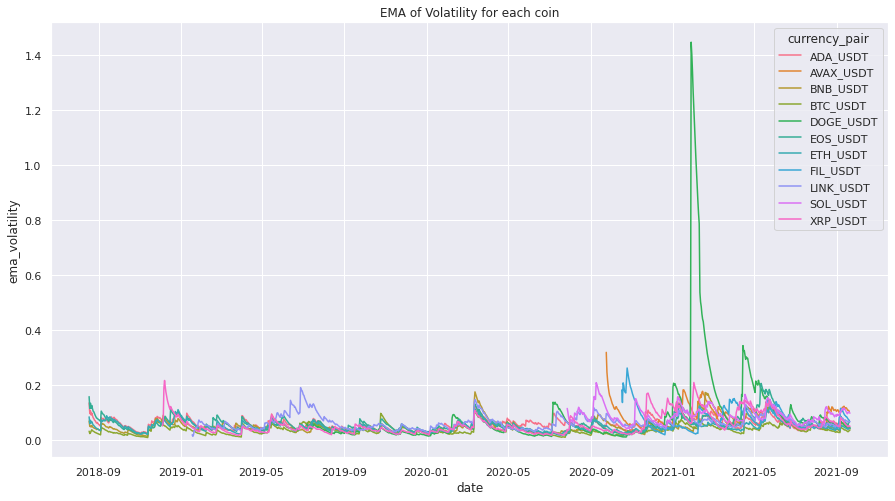

In [6]:
ema_df_daily = get_df_with_coin_price_volatility(daily_vix_ema, display_plot=True)
display(ema_df_daily)

## 5 min

In [7]:
frequency = "5min"
compute_5min_vix_ema = lambda data: compute_volatility_for_each_coin(
    data, freq=frequency, span=18
)
vix_ema_5min = ramccsta.compute_stats_for_universe(
    universe, config, compute_5min_vix_ema
)

Removed 36 / 763283 = 0.00% rows
Removed 36 / 780707 = 0.00% rows
Removed 16 / 362591 = 0.00% rows
Removed 36 / 780749 = 0.00% rows
Removed 35 / 747070 = 0.00% rows
Removed 31 / 607430 = 0.01% rows
Removed 32 / 618181 = 0.01% rows


ema_volatility
currency_pair date                                     
ADA_USDT      2018-08-16 20:00:00-04:00             NaN
              2018-08-16 20:05:00-04:00             NaN
              2018-08-16 20:10:00-04:00        0.000603
              2018-08-16 20:15:00-04:00        0.000425
              2018-08-16 20:20:00-04:00        0.001439
...                                                 ...
XRP_USDT      2021-09-21 18:50:00-04:00        0.006339
              2021-09-21 18:55:00-04:00        0.006714
              2021-09-21 19:00:00-04:00        0.006792
              2021-09-21 19:05:00-04:00        0.006533
              2021-09-21 19:10:00-04:00        0.006414

[2742000 rows x 1 columns]

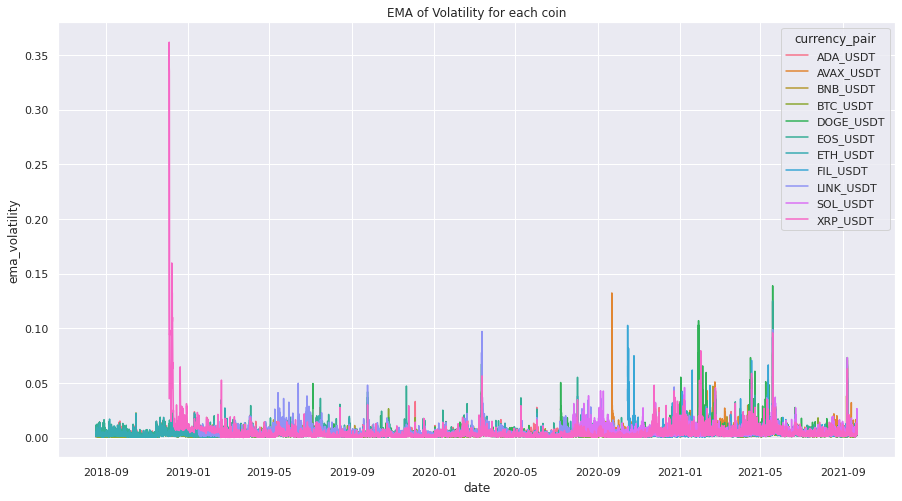

In [8]:
ema_df_5min = get_df_with_coin_price_volatility(vix_ema_5min, display_plot=True)
display(ema_df_5min)

## Volatility for the whole period (1-day frequency)

In [10]:
frequency = "1D"
compute_daily_close = lambda data: get_daily_close(data, freq=frequency)
daily_close = ramccsta.compute_stats_for_universe(
    universe, config, compute_daily_close
)

Removed 36 / 763283 = 0.00% rows
Removed 36 / 780707 = 0.00% rows
Removed 16 / 362591 = 0.00% rows
Removed 36 / 780749 = 0.00% rows
Removed 35 / 747070 = 0.00% rows
Removed 31 / 607430 = 0.01% rows
Removed 32 / 618181 = 0.01% rows


currency_pair
ADA_USDT     0.060776
AVAX_USDT    0.095851
BNB_USDT     0.056449
BTC_USDT     0.039844
DOGE_USDT    0.181408
EOS_USDT     0.062374
ETH_USDT     0.051847
FIL_USDT     0.083435
LINK_USDT    0.070473
SOL_USDT     0.096528
XRP_USDT     0.065472
Name: close, dtype: float64

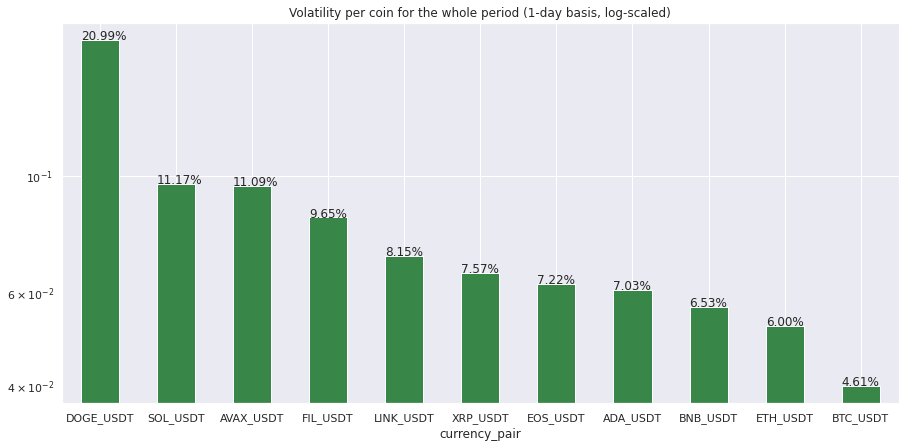

In [11]:
std_df = get_overall_returns_volatility(daily_close, display_plot=True)
display(std_df)

# Test for stationarity of volatility

In [12]:
test_results = perform_adf_test(ema_df_daily)
display(test_results)

,ADF Statistic,p-value,is_unit_root_and_non-stationary (5% sign. level)
ADA_USDT,-5.419227,3.086075e-06,False
AVAX_USDT,-6.321419,3.059519e-08,False
BNB_USDT,-5.326428,4.826044e-06,False
BTC_USDT,-5.544240,1.674843e-06,False
DOGE_USDT,-4.991235,2.309687e-05,False
EOS_USDT,-4.550113,1.594639e-04,False
ETH_USDT,-5.771600,5.376380e-07,False
FIL_USDT,-2.565722,1.002909e-01,True
LINK_USDT,-4.643783,1.071815e-04,False
SOL_USDT,-4.649945,1.043902e-04,False


After test results we see that __FIL/USDT__ volatility over 1-day is failed to pass the stationarity test. The graph below confirms the persistence of trend: seems like the coin was too volatile right after the listing and failed to keep the same levels during its trading lifetime.

<AxesSubplot:xlabel='date', ylabel='ema_volatility'>

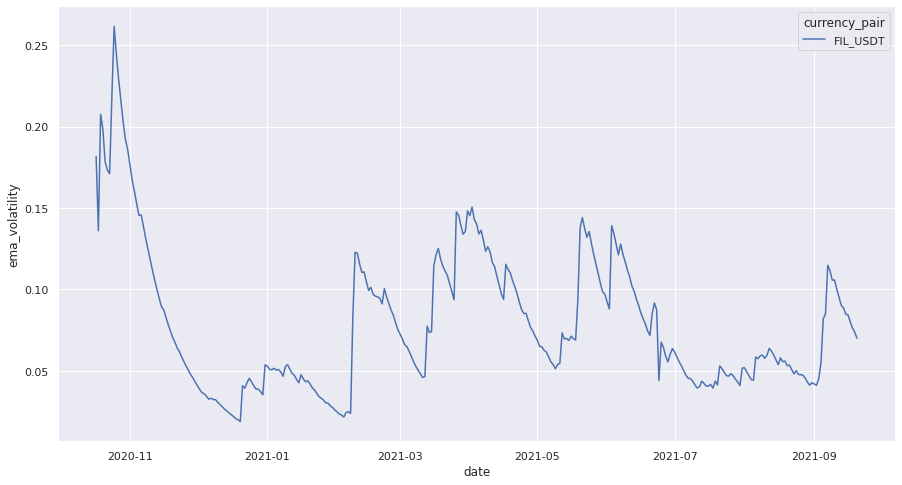

In [14]:
# TODO(Max): check scatter-plotting functions in core.plotting.py
sns.lineplot(
    data=ema_df_daily.loc[["FIL_USDT"]].reset_index(),
    x="date",
    y="ema_volatility",
    hue="currency_pair",
)

# Regression Analysis

In [15]:
frequency = "1D"
compute_daily_vix_ema_and_volume = lambda data: get_df_with_volume_and_volatility(
    data, freq=frequency, span=18
)
daily_vix_ema_volume = ramccsta.compute_stats_for_universe(
    vendor_universe=universe,
    config=config,
    stats_func=compute_daily_vix_ema_and_volume,
)

Removed 36 / 763283 = 0.00% rows
Removed 36 / 780707 = 0.00% rows
Removed 16 / 362591 = 0.00% rows
Removed 36 / 780749 = 0.00% rows
Removed 35 / 747070 = 0.00% rows
Removed 31 / 607430 = 0.01% rows
Removed 32 / 618181 = 0.01% rows


## Regression Results

In [16]:
regression_results = run_regressions(daily_vix_ema_volume, lag_volume=True)

for coin in regression_results.keys():
    print(f"{coin}:")
    display(regression_results[coin])

ADA_USDT:


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         ema_volatility   R-squared:                       0.379
Model:                            OLS   Adj. R-squared:                  0.379
Method:                 Least Squares   F-statistic:                     689.6
Date:                Thu, 25 Nov 2021   Prob (F-statistic):          5.41e-119
Time:                        22:50:34   Log-Likelihood:                 3102.4
No. Observations:                1130   AIC:                            -6201.
Df Residuals:                    1128   BIC:                            -6191.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0453      0.001     68.159      0.000       0.044       0.047
lag_volume  3.722e-11   1.42e-12     26.260      0.000    3.44e-11       4e-11
==============================================================================
Omnibus:                      102.137   Durbin-Watson:                   0.345
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              140.864
Skew:                           0.712   Prob(JB):                     2.58e-31
Kurtosis:                       3.983   Cond. No.                     6.73e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.73e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

AVAX_USDT:


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         ema_volatility   R-squared:                       0.060
Model:                            OLS   Adj. R-squared:                  0.057
Method:                 Least Squares   F-statistic:                     22.80
Date:                Thu, 25 Nov 2021   Prob (F-statistic):           2.61e-06
Time:                        22:50:34   Log-Likelihood:                 678.13
No. Observations:                 362   AIC:                            -1352.
Df Residuals:                     360   BIC:                            -1344.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0863      0.002     38.506      0.000       0.082       0.091
lag_volume  1.137e-09   2.38e-10      4.775      0.000    6.69e-10     1.6e-09
==============================================================================
Omnibus:                      105.007   Durbin-Watson:                   0.075
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              281.195
Skew:                           1.373   Prob(JB):                     8.70e-62
Kurtosis:                       6.331   Cond. No.                     1.08e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.08e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

BNB_USDT:


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         ema_volatility   R-squared:                       0.080
Model:                            OLS   Adj. R-squared:                  0.079
Method:                 Least Squares   F-statistic:                     98.57
Date:                Thu, 25 Nov 2021   Prob (F-statistic):           2.50e-22
Time:                        22:50:34   Log-Likelihood:                 2634.5
No. Observations:                1131   AIC:                            -5265.
Df Residuals:                    1129   BIC:                            -5255.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0459      0.001     56.139      0.000       0.044       0.048
lag_volume  6.321e-10   6.37e-11      9.928      0.000    5.07e-10    7.57e-10
==============================================================================
Omnibus:                      496.987   Durbin-Watson:                   0.080
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2322.551
Skew:                           2.059   Prob(JB):                         0.00
Kurtosis:                       8.686   Cond. No.                     1.50e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.5e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

BTC_USDT:


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         ema_volatility   R-squared:                       0.048
Model:                            OLS   Adj. R-squared:                  0.047
Method:                 Least Squares   F-statistic:                     57.32
Date:                Thu, 25 Nov 2021   Prob (F-statistic):           7.68e-14
Time:                        22:50:34   Log-Likelihood:                 3134.7
No. Observations:                1131   AIC:                            -6265.
Df Residuals:                    1129   BIC:                            -6255.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0348      0.001     69.444      0.000       0.034       0.036
lag_volume  6.969e-11    9.2e-12      7.571      0.000    5.16e-11    8.77e-11
==============================================================================
Omnibus:                      238.957   Durbin-Watson:                   0.136
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              497.159
Skew:                           1.198   Prob(JB):                    1.10e-108
Kurtosis:                       5.193   Cond. No.                     6.06e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.06e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

DOGE_USDT:


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         ema_volatility   R-squared:                       0.549
Model:                            OLS   Adj. R-squared:                  0.549
Method:                 Least Squares   F-statistic:                     982.4
Date:                Thu, 25 Nov 2021   Prob (F-statistic):          1.22e-141
Time:                        22:50:34   Log-Likelihood:                 709.17
No. Observations:                 808   AIC:                            -1414.
Df Residuals:                     806   BIC:                            -1405.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0487      0.004     13.080      0.000       0.041       0.056
lag_volume  1.416e-11   4.52e-13     31.343      0.000    1.33e-11     1.5e-11
==============================================================================
Omnibus:                      960.228   Durbin-Watson:                   0.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           133339.912
Skew:                           5.726   Prob(JB):                         0.00
Kurtosis:                      64.882   Cond. No.                     8.64e+09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.64e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

EOS_USDT:


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         ema_volatility   R-squared:                       0.433
Model:                            OLS   Adj. R-squared:                  0.433
Method:                 Least Squares   F-statistic:                     861.8
Date:                Thu, 25 Nov 2021   Prob (F-statistic):          3.41e-141
Time:                        22:50:34   Log-Likelihood:                 2785.0
No. Observations:                1130   AIC:                            -5566.
Df Residuals:                    1128   BIC:                            -5556.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0427      0.001     54.258      0.000       0.041       0.044
lag_volume  7.765e-10   2.65e-11     29.356      0.000    7.25e-10    8.28e-10
==============================================================================
Omnibus:                      197.225   Durbin-Watson:                   0.357
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              678.938
Skew:                           0.829   Prob(JB):                    3.72e-148
Kurtosis:                       6.417   Cond. No.                     3.82e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.82e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

ETH_USDT:


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         ema_volatility   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     20.91
Date:                Thu, 25 Nov 2021   Prob (F-statistic):           5.35e-06
Time:                        22:50:34   Log-Likelihood:                 2963.2
No. Observations:                1131   AIC:                            -5922.
Df Residuals:                    1129   BIC:                            -5912.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0475      0.001     81.481      0.000       0.046       0.049
lag_volume  6.688e-11   1.46e-11      4.573      0.000    3.82e-11    9.56e-11
==============================================================================
Omnibus:                      176.523   Durbin-Watson:                   0.096
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              271.778
Skew:                           1.063   Prob(JB):                     9.64e-60
Kurtosis:                       4.116   Cond. No.                     4.43e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.43e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

FIL_USDT:


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         ema_volatility   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     2.264
Date:                Thu, 25 Nov 2021   Prob (F-statistic):              0.133
Time:                        22:50:34   Log-Likelihood:                 584.44
No. Observations:                 339   AIC:                            -1165.
Df Residuals:                     337   BIC:                            -1157.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0805      0.003     31.598      0.000       0.075       0.086
lag_volume -4.997e-10   3.32e-10     -1.505      0.133   -1.15e-09    1.54e-10
==============================================================================
Omnibus:                       67.388   Durbin-Watson:                   0.063
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              109.878
Skew:                           1.166   Prob(JB):                     1.38e-24
Kurtosis:                       4.531   Cond. No.                     8.31e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.31e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

LINK_USDT:


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         ema_volatility   R-squared:                       0.292
Model:                            OLS   Adj. R-squared:                  0.291
Method:                 Least Squares   F-statistic:                     402.9
Date:                Thu, 25 Nov 2021   Prob (F-statistic):           2.70e-75
Time:                        22:50:34   Log-Likelihood:                 2330.3
No. Observations:                 978   AIC:                            -4657.
Df Residuals:                     976   BIC:                            -4647.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0489      0.001     45.665      0.000       0.047       0.051
lag_volume  1.518e-09   7.56e-11     20.073      0.000    1.37e-09    1.67e-09
==============================================================================
Omnibus:                      227.903   Durbin-Watson:                   0.285
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              517.308
Skew:                           1.265   Prob(JB):                    4.65e-113
Kurtosis:                       5.508   Cond. No.                     2.12e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.12e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

SOL_USDT:


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         ema_volatility   R-squared:                       0.053
Model:                            OLS   Adj. R-squared:                  0.051
Method:                 Least Squares   F-statistic:                     23.37
Date:                Thu, 25 Nov 2021   Prob (F-statistic):           1.88e-06
Time:                        22:50:34   Log-Likelihood:                 906.04
No. Observations:                 421   AIC:                            -1808.
Df Residuals:                     419   BIC:                            -1800.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0884      0.002     56.453      0.000       0.085       0.091
lag_volume  2.715e-10   5.62e-11      4.834      0.000    1.61e-10    3.82e-10
==============================================================================
Omnibus:                       74.731   Durbin-Watson:                   0.143
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              119.744
Skew:                           1.083   Prob(JB):                     9.95e-27
Kurtosis:                       4.462   Cond. No.                     3.18e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.18e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

XRP_USDT:


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         ema_volatility   R-squared:                       0.219
Model:                            OLS   Adj. R-squared:                  0.218
Method:                 Least Squares   F-statistic:                     285.6
Date:                Thu, 25 Nov 2021   Prob (F-statistic):           1.13e-56
Time:                        22:50:34   Log-Likelihood:                 2101.1
No. Observations:                1022   AIC:                            -4198.
Df Residuals:                    1020   BIC:                            -4188.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0450      0.001     38.711      0.000       0.043       0.047
lag_volume  3.272e-10   1.94e-11     16.899      0.000    2.89e-10    3.65e-10
==============================================================================
Omnibus:                      269.397   Durbin-Watson:                   0.132
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              683.367
Skew:                           1.378   Prob(JB):                    4.06e-149
Kurtosis:                       5.906   Cond. No.                     7.18e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.18e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

As one can see, for all the currency pairs the regression of volatility to volume with intercept shows significance of volume coefficient (as well as lagged volume). The only exception is __FIL/USDT__, that also failed the stationarity test above.

## Correlation and Plots

ema_volatility    volume
currency_pair                                         
ADA_USDT      ema_volatility        1.000000  0.601409
              volume                0.601409  1.000000
AVAX_USDT     ema_volatility        1.000000  0.218718
              volume                0.218718  1.000000
BNB_USDT      ema_volatility        1.000000  0.282601
              volume                0.282601  1.000000
BTC_USDT      ema_volatility        1.000000  0.221162
              volume                0.221162  1.000000
DOGE_USDT     ema_volatility        1.000000  0.767243
              volume                0.767243  1.000000
EOS_USDT      ema_volatility        1.000000  0.646731
              volume                0.646731  1.000000
ETH_USDT      ema_volatility        1.000000  0.128393
              volume                0.128393  1.000000
FIL_USDT      ema_volatility        1.000000 -0.086705
              volume               -0.086705  1.000000
LINK_USDT     ema_volatility        1.000000  0.538290
              volume                0.538290  1.000000
SOL_USDT      ema_volatility        1.000000  0.218375
              volume                0.218375  1.000000
XRP_USDT      ema_volatility        1.000000  0.460165
              volume                0.460165  1.000000

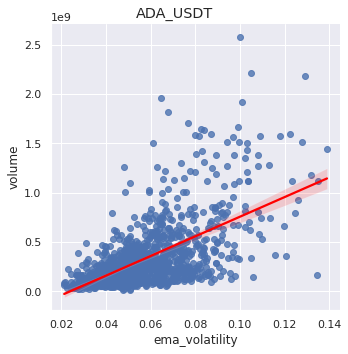

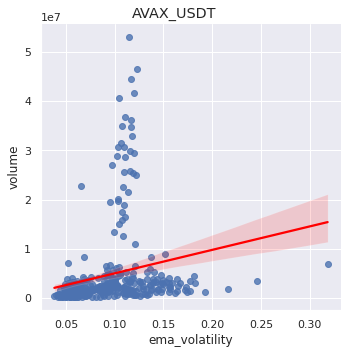

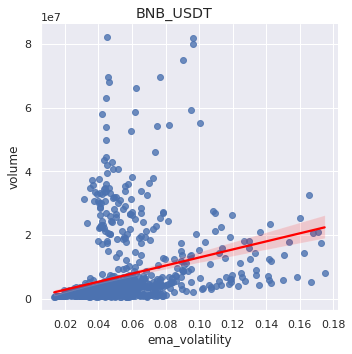

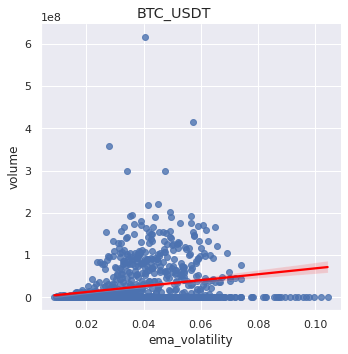

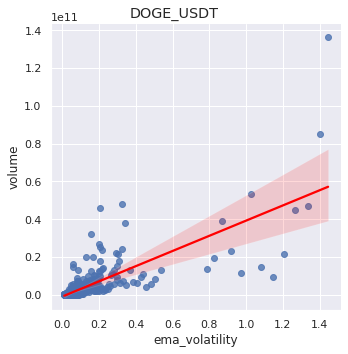

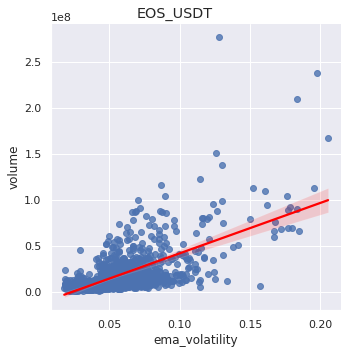

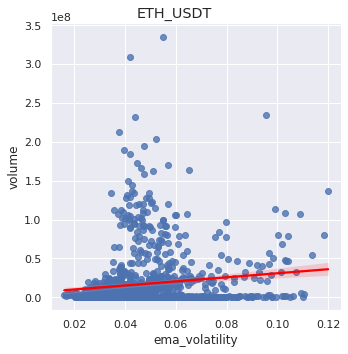

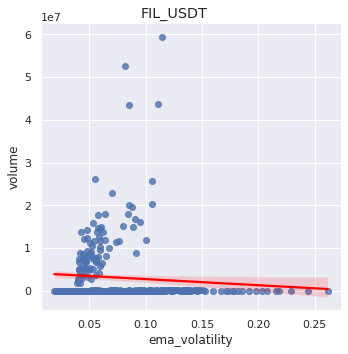

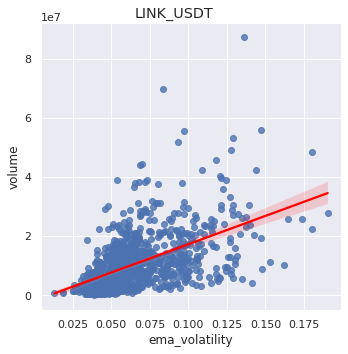

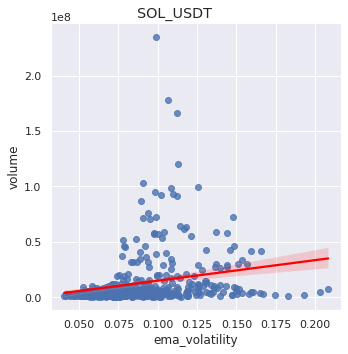

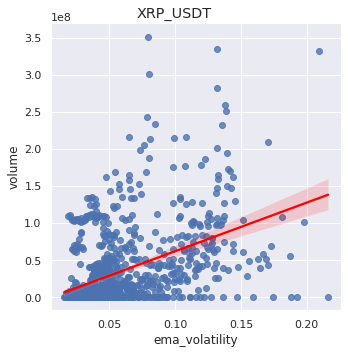

In [17]:
corr_df = calculate_corr_and_plot_scatter_plots(
    daily_vix_ema_volume, display_plot=True
)
display(corr_df)